## 🔍 Diagnostic Analytics — Predictive Maintenance

**Goal:** Explore relationships to explain *why* failures happen (drivers of risk). Uses the same synthetic data generation as the Descriptive notebook for consistency.

#### 📦 Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

plt.rcParams['figure.figsize']=(7,4)
pd.set_option('display.max_columns',50)

#### 📥 Read Data

In [ ]:
df = pd.read_csv('data/PdM_data.csv')

df.head()

,asset_id,age,load_factor,ambient,temperature,vibration,pressure,current,fail_next_24h,rul_hours
0,0,175.027531,1.037522,28.639848,75.772244,0.777042,32.456836,15.351275,1,112.743486
1,0,176.027531,0.792100,24.400995,74.248343,0.786263,33.293140,12.791664,0,114.756578
2,0,177.027531,0.641573,28.776035,70.731868,0.752131,30.066905,10.782674,1,127.546885
3,0,178.027531,0.638114,25.154667,68.649198,0.672473,34.409435,10.587894,1,149.582275
4,0,179.027531,0.632052,36.919182,69.473329,0.667970,32.937247,12.690585,0,130.314500


#### 📉 Cross-correlation heatmap for numeric features

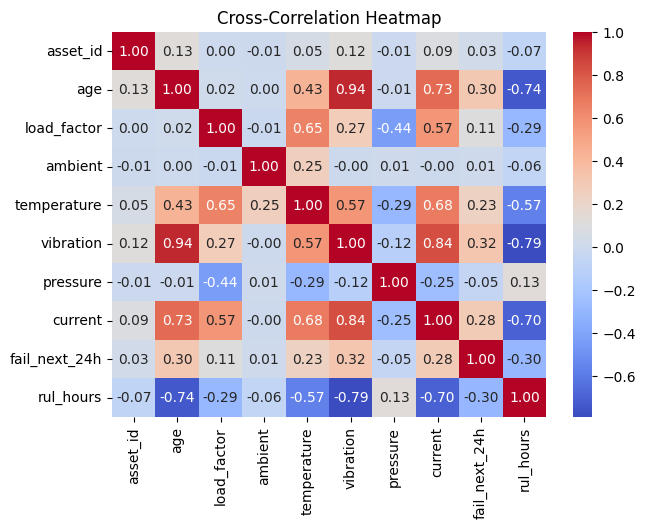

In [3]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Cross-Correlation Heatmap')
plt.show()

#### 🧭 Questions
- Which features are most associated with failures?
- How do key sensors relate to RUL?

,age,load_factor,ambient,temperature,vibration,pressure,current,fail_next_24h,rul_hours
age,1.000000,0.016606,0.001787,0.432665,0.941832,-0.009537,0.734939,0.302053,-0.735523
load_factor,0.016606,1.000000,-0.013597,0.646645,0.272653,-0.438512,0.572946,0.108137,-0.290556
ambient,0.001787,-0.013597,1.000000,0.253805,-0.004401,0.012647,-0.002921,0.014557,-0.058570
temperature,0.432665,0.646645,0.253805,1.000000,0.569886,-0.285905,0.675055,0.226190,-0.567854
vibration,0.941832,0.272653,-0.004401,0.569886,1.000000,-0.121965,0.836230,0.321588,-0.789038
pressure,-0.009537,-0.438512,0.012647,-0.285905,-0.121965,1.000000,-0.253412,-0.050142,0.131092
current,0.734939,0.572946,-0.002921,0.675055,0.836230,-0.253412,1.000000,0.284097,-0.704129
fail_next_24h,0.302053,0.108137,0.014557,0.226190,0.321588,-0.050142,0.284097,1.000000,-0.296712
rul_hours,-0.735523,-0.290556,-0.058570,-0.567854,-0.789038,0.131092,-0.704129,-0.296712,1.000000


Correlation with fail_next_24h:


fail_next_24h    1.000000
vibration        0.321588
age              0.302053
current          0.284097
temperature      0.226190
load_factor      0.108137
ambient          0.014557
pressure        -0.050142
rul_hours       -0.296712
Name: fail_next_24h, dtype: float64

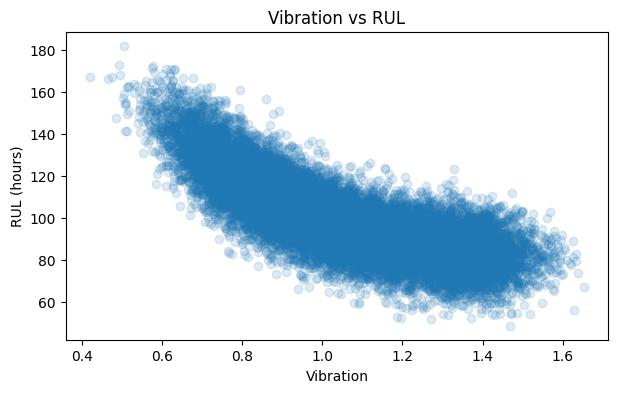

In [4]:
corr=df[['age','load_factor','ambient','temperature','vibration','pressure','current','fail_next_24h','rul_hours']].corr()
display(corr)
print('Correlation with fail_next_24h:')
display(corr['fail_next_24h'].sort_values(ascending=False))

plt.scatter(df['vibration'], df['rul_hours'], alpha=0.15)
plt.title('Vibration vs RUL')
plt.xlabel('Vibration')
plt.ylabel('RUL (hours)')
plt.show()

#### 🧪 Permutation Importance (Classification proxy)
We fit a quick classifier to estimate feature importance for failure in the next 24h.

,permutation_importance
temperature,0.001479
vibration,0.000792
load_factor,0.000333
pressure,-0.000750
ambient,-0.001000
age,-0.001021
current,-0.002292


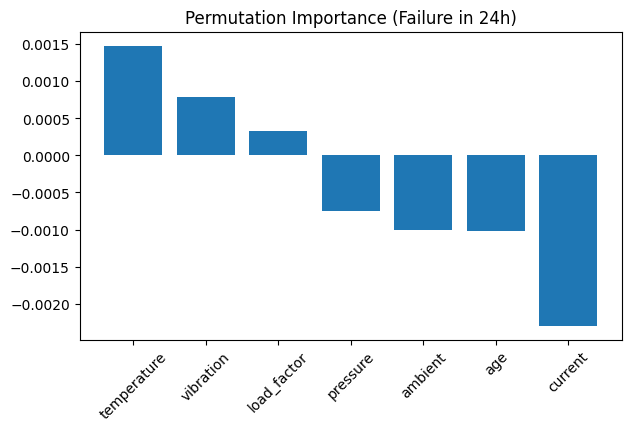

In [5]:
features=['age','load_factor','ambient','temperature','vibration','pressure','current']
X=df[features]; y=df['fail_next_24h']
Xtr,Xte,ytr,yte=train_test_split(X,y,test_size=0.25,random_state=518,stratify=y)
clf=RandomForestClassifier(n_estimators=300,random_state=518)
clf.fit(Xtr,ytr)
perm=permutation_importance(clf,Xte,yte,n_repeats=10,random_state=518)
imp=pd.Series(perm.importances_mean,index=features).sort_values(ascending=False)
display(imp.to_frame('permutation_importance'))
plt.bar(imp.index,imp.values); plt.title('Permutation Importance (Failure in 24h)'); plt.xticks(rotation=45); plt.show()

#### 🧾 Takeaways
- Temperature, vibration, current, and age tend to be strong drivers of risk.
- These findings inform feature engineering and model design used in the Predictive notebook.